**AdaBoost (Adaptive Boosting)**

AdaBoost was introduced in 1995 by Freund and Schapire.

* AdaBoost combines a lot of "weak learner" to make classisfications. The weak learners are almost always <b>stumps</b>.
* Some stumps get more say in the classification than others.
* Each stump is made by taking the previous stump's mistakes into account.

AdaBoost is a machine learning algorithm that works by combining multiple simple models, called weak learners, to make accurate predictions. 

Here's a simplified explanation:

1. **Starting Point**: We begin by training a weak learner on the original data, where each data point has the same importance.

2. **Sequential Learning**: AdaBoost trains a sequence of weak learners, each focusing on the mistakes made by the previous one. 

3. **Weighted Data**: At each step, AdaBoost gives more weight to the data points that were incorrectly predicted by the previous weak learner. This makes the next weak learner focus more on these difficult examples.

4. **Combining Predictions**: After training all the weak learners, AdaBoost combines their predictions using a weighted majority vote. This final prediction is usually more accurate than the individual predictions of the weak learners.

In summary, AdaBoost learns from its mistakes and adapts over time to improve its performance. It's like having a team of learners, where each member specializes in different areas and collectively they make better decisions.

<b>How to create a Forest of Stumps using AdaBoost:</b>

First we will start with some data. We create a Forest of Stumps with AdaBoost to predict machine failures based on sensor data.

In [775]:
import pandas as pd
import numpy as np

input_file = "machinedata.csv"
df = pd.read_csv(input_file)

df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,31.37,False
1,True,True,31.92,True
2,False,True,28.80,False
3,True,False,34.46,False
4,True,True,29.31,True
5,False,True,30.74,True
6,True,True,32.75,False
7,False,True,30.13,False
8,True,False,30.41,True
9,False,True,30.64,False


The first thing we do is give each sample a weight that indicates how important it is to be correctly classified.

At the start, all samples get the same weight: 1 / total number of samples

In our example, it is 1 / 10

However, after we make the first stump, these weights will change in order to guide how the next stump is created.

In [776]:
total_samples = df.shape[0] # total rows
df["Sample_Weight"] = 1 / total_samples
df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure,Sample_Weight
0,True,False,31.37,False,0.1
1,True,True,31.92,True,0.1
2,False,True,28.80,False,0.1
3,True,False,34.46,False,0.1
4,True,True,29.31,True,0.1
5,False,True,30.74,True,0.1
6,True,True,32.75,False,0.1
7,False,True,30.13,False,0.1
8,True,False,30.41,True,0.1
9,False,True,30.64,False,0.1


In [777]:
print(list(df.columns[:3])) # features

['Capacitive_Sensor', 'Inductive_Sensor', 'Temperature_Sensor']


<b>1. Now we need to make the first stump in the forest/ Building a stump with the GINI index:</b>

This is done by finding the variables 'Capacitive_Sensor', 'Inductive_Sensor' or 'Temperature_Sensor' that does the best job classifying the samples.

NOTE: Because all of the weights are the same, we can ignore them right now.

Start by seeing how well "Capacitive_Sensor" classifies the samples.

In [778]:
df[["Capacitive_Sensor", "Failure"]]

,Capacitive_Sensor,Failure
0,True,False
1,True,True
2,False,False
3,True,False
4,True,True
5,False,True
6,True,False
7,False,False
8,True,True
9,False,False


Of the 6 samples with Capacitive_Sensor is True, 3 were correctly classified as having Machine Failure and 3 were incorrectly classified.

Of the 4 samples with Capacitive_Sensor is False, 3 were correctly classified as <b>not</b> having Machine Failure and 1 were incorrectly classified.

In [779]:
# Calculate the Gini Impurity for "Capacitive_Sensor"

gini_left = np.round((1 - np.square(3/6) - np.square(3/6)), decimals=2)
gini_right = np.round((1 - np.square(3/4) - np.square(1/4)), decimals=2)
total_gini = np.round((6/10)*gini_left + (4/10)*gini_right, decimals=2)
total_gini

0.45

Now we do the same thing for "Inductive_Sensor".

In [780]:
df[["Inductive_Sensor", "Failure"]]

,Inductive_Sensor,Failure
0,False,False
1,True,True
2,True,False
3,False,False
4,True,True
5,True,True
6,True,False
7,True,False
8,False,True
9,True,False


Of the 7 samples with Inductive_Sensor is True, 3 were correctly classified as having machine Failure and 4 were incorrectly classified.

Of the 3 samples with Inductive_Sensor is False, 2 were correctly classified and 1 were incorrectly classified.

In [781]:
# Calculate the Gini Impurity for "Inductive_Sensor"

gini_left = np.round((1 - np.square(3/7) - np.square(4/7)), decimals=2)
gini_right = np.round((1 - np.square(2/3) - np.square(1/3)), decimals=2)
total_gini = np.round((7/10)*gini_left + (3/10)*gini_right, decimals=2)
total_gini

0.48

Now we do the same thing for "Temperature_Sensor".

In [782]:
df[["Temperature_Sensor", "Failure"]]

,Temperature_Sensor,Failure
0,31.37,False
1,31.92,True
2,28.80,False
3,34.46,False
4,29.31,True
5,30.74,True
6,32.75,False
7,30.13,False
8,30.41,True
9,30.64,False


Notice that "Temperature_Sensor" contains numeric data, calculating the Gini Impurity is a little more involved.

Step 1: The first thing we do is sort the rows from lowest to the highest value.

In [783]:
sorted_by_temperature_df = df.sort_values("Temperature_Sensor", ascending=True)
sorted_by_temperature_df[["Temperature_Sensor", "Failure"]]

,Temperature_Sensor,Failure
2,28.80,False
4,29.31,True
7,30.13,False
8,30.41,True
9,30.64,False
5,30.74,True
0,31.37,False
1,31.92,True
6,32.75,False
3,34.46,False


Step 2: Calculate the average Temperature for all adjacent data

In [784]:
my_list = []
averages = []

for temp in sorted_by_temperature_df["Temperature_Sensor"]:
    my_list.append(temp)

# Calculate the average for each adjacent pair and round to 2 decimals
for i in range(len(my_list) - 1):
    average = round((my_list[i] + my_list[i + 1]) / 2, 2)
    averages.append(average)

print(my_list)
print(averages)
sorted_by_temperature_df[["Temperature_Sensor", "Failure"]]

[28.8, 29.31, 30.13, 30.41, 30.64, 30.74, 31.37, 31.92, 32.75, 34.46]
[29.05, 29.72, 30.27, 30.52, 30.69, 31.05, 31.65, 32.34, 33.61]


,Temperature_Sensor,Failure
2,28.80,False
4,29.31,True
7,30.13,False
8,30.41,True
9,30.64,False
5,30.74,True
0,31.37,False
1,31.92,True
6,32.75,False
3,34.46,False


Step 3: Calculate the impurity values for each average temperature.

1. Temperature < 29.05 --> Gini Impurity = 0.445
2. Temperature < 29.72 --> Gini Impurity = 0.476
3. Temperature < 30.27 --> Gini Impurity = 0.476
4. Temperature < 30.52 --> Gini Impurity = 0.45
5. Temperature < 30.69 --> Gini Impurity = 0.48
6. Temperature < 31.05 --> Gini Impurity = 0.45
7. Temperature < 31.65 --> Gini Impurity = 0.476
8. Temperature < 32.34 --> Gini Impurity = 0.476
9. Temperature < 33.61 --> Gini Impurity = 0.445

In [785]:
# 1. Temperature < 29.05 
gini_left = 0
gini_right = np.round(1-np.square(5/9)-np.square(4/9), decimals=2)
total_gini = np.round(0 + (9/10)*gini_right, decimals=2)
total_gini

0.44

In [786]:
# 2. Temperature < 29.72
gini_left = np.round(1-np.square(1/2)-np.square(1/2), decimals=2)
gini_right = np.round(1-np.square(5/8)-np.square(3/8), decimals=2)
total_gini = np.round((2/10)*gini_left + (8/10)*gini_right, decimals=2)
total_gini

0.48

In [787]:
# 3. Temperature < 30.27
gini_left = np.round(1-np.square(1/3)-np.square(2/3), decimals=2)
gini_right = np.round(1-np.square(4/7)-np.square(3/7), decimals=2)
total_gini = np.round((3/10)*gini_left + (7/10)*gini_right, decimals=2)
total_gini

0.48

In [788]:
# 4. Temperature < 30.52
gini_left = np.round(1-np.square(2/4)-np.square(2/4), decimals=2)
gini_right = np.round(1-np.square(4/6)-np.square(2/6), decimals=2)
total_gini = np.round((4/10)*gini_left + (6/10)*gini_right, decimals=2)
total_gini

0.46

In [789]:
# 5. Temperature < 30.69
gini_left = np.round(1-np.square(2/5)-np.square(3/5), decimals=2)
gini_right = np.round(1-np.square(3/5)-np.square(2/5), decimals=2)
total_gini = np.round((5/10)*gini_left + (5/10)*gini_right, decimals=2)
total_gini

0.48

In [790]:
# 6. Temperature < 31.05
gini_left = np.round(1-np.square(3/6)-np.square(3/6), decimals=2)
gini_right = np.round(1-np.square(3/4)-np.square(1/4), decimals=2)
total_gini = np.round((6/10)*gini_left + (4/10)*gini_right, decimals=2)
total_gini

0.45

In [791]:
# 7. Temperature < 31.65
gini_left = np.round(1-np.square(3/7)-np.square(4/7), decimals=2)
gini_right = np.round(1-np.square(2/3)-np.square(1/3), decimals=2)
total_gini = np.round((7/10)*gini_left + (3/10)*gini_right, decimals=2)
total_gini

0.48

In [792]:
# 8. Temperature < 32.34
gini_left = np.round(1-np.square(4/8)-np.square(4/8), decimals=2)
gini_right = np.round(1-np.square(2/2)-np.square(0/2), decimals=2)
total_gini = np.round((8/10)*gini_left + (2/10)*gini_right, decimals=2)
total_gini

0.4

In [793]:
# 9. Temperature < 33.61
gini_left = np.round(1-np.square(4/9)-np.square(5/9), decimals=2)
gini_right = np.round(1-np.square(1/1)-np.square(0/1), decimals=2)
total_gini = np.round((9/10)*gini_left + (1/10)*gini_right, decimals=2)
total_gini

0.44

From the above, the lowest Gini Impurity occurs when we separate using Temperature < 32.34

So this is the cutoff and impurity value we will use when we compare Temperature to Capacitive_Sensor or Inductive_Sensor.

* Of the 2 samples with Temperature > 32.34 is True, 0 were correctly classified as having machine Failure and 2 were incorrectly classified.

* Of the 8 samples with Temperature > 32.34 is False, 4 were correctly classified as and 4 were incorrectly classified.

In [794]:
# Calculate the Gini Impurity for "Temperature_Sensor" > 32.34

gini_left = np.round((1 - np.square(0/2) - np.square(2/2)), decimals=2)
gini_right = np.round((1 - np.square(4/8) - np.square(4/8)), decimals=2)
total_gini = np.round((2/10)*gini_left + (8/10)*gini_right, decimals=2)
total_gini

0.4

So by comparing the Gini Index for:
* Capacitive_Sensor: 0.45 
* Inductive_Sensor: 0.48
* Temperature_Sensor: 0.4

The Gini Index for Temperature_Sensor is the lowest, so this will be the first stump in the forest.

<b>2. Now we need to determine how much say this stump will have in the final classification.</b>

Remember, some stumps get more say in the final classification than others.

We determine how much say a stump has in the final classification based on how well it classified the samples.

By looking at the previous Temperature_Sensor classification below, this stump made 5 errors:

* Of the 1 sample with Temperature > 32,34 is True, 0 were correctly classified as having machine Failure and <b><u>2 were incorrectly classified</b></u>.

* Of the 9 samples with Temperature > 32,34 is False, 4 were correctly classified as and <b><u>4 were incorrectly classified</b></u>.

The data with index 1, 3, 4, 5, 6 and 8 had Machine Failures, but the stump says they do not.

In [795]:
print(df.loc[1])
print(df.loc[3])
print(df.loc[4])
print(df.loc[5])
print(df.loc[6])
print(df.loc[8])

Capacitive_Sensor      True
Inductive_Sensor       True
Temperature_Sensor    31.92
Failure                True
Sample_Weight           0.1
Name: 1, dtype: object
Capacitive_Sensor      True
Inductive_Sensor      False
Temperature_Sensor    34.46
Failure               False
Sample_Weight           0.1
Name: 3, dtype: object
Capacitive_Sensor      True
Inductive_Sensor       True
Temperature_Sensor    29.31
Failure                True
Sample_Weight           0.1
Name: 4, dtype: object
Capacitive_Sensor     False
Inductive_Sensor       True
Temperature_Sensor    30.74
Failure                True
Sample_Weight           0.1
Name: 5, dtype: object
Capacitive_Sensor      True
Inductive_Sensor       True
Temperature_Sensor    32.75
Failure               False
Sample_Weight           0.1
Name: 6, dtype: object
Capacitive_Sensor      True
Inductive_Sensor      False
Temperature_Sensor    30.41
Failure                True
Sample_Weight           0.1
Name: 8, dtype: object


The Total Error for a stump is the sum of the weights associated with the <b><u>incorrectly classified samples</b></u>.

Thus, in this case, the Total Error is: <b><u>0.75</b></u>

NOTE: Because all of the Sample Weights add up to 1, Total Error will always be between 0, for a perfect stump, and 1, for a horrible stump.

In [796]:
total_error_first_stump = (1/8)*6
total_error_first_stump

0.75

The Amount of Say this stump has in the final classification with the following formula:

<img src="amount-of-say-formula.webp">

In [797]:
amount_of_say_first_stump = np.round((1/2)*np.log((1-total_error_first_stump)/total_error_first_stump), decimals=2)
amount_of_say_first_stump

-0.55

So, the Amount of Say that this stump has on the final classification is <b>-0.55</b>.

We can draw a graph of the Amount of Say by plugging in a bunch of numbers between 0 and 1 for Total Error.

<img src="amount-of-say-vs-total-error-graph.webp">

The blue line tells us the Amount of Say for Total Error values between 0 and 1.

* When a stump does a good job, and the Total Error is small, then the Amount of Say is a relatively large positive value.

* When a stump is not doing a good job at classification (i.e. half of the samples are correctly classified and half are incorrectly classified) and Total Error = 0.5, then the Amount of Say will be 0.

* When a stump does a terrible job and the Total Error is close to 1 (i.e. if the stump consistently gives the opposite classification), then the Amount of Say will be a large negative value.

So in our case above (Total Error is 0.75 and the Amount of Say is -0.55), if a stump votes Yes/ True for Machine "Failure", the negative Amount of Say will turn that vote into "Not Machine Failure".

Now, let's work out how much say Capacitive_Sensor stump would have had if it had been the best stump.

In [798]:
df[["Capacitive_Sensor", "Failure"]]

,Capacitive_Sensor,Failure
0,True,False
1,True,True
2,False,False
3,True,False
4,True,True
5,False,True
6,True,False
7,False,False
8,True,True
9,False,False


Of the 6 samples with Capacitive_Sensor is True, 3 were correctly classified as having Machine Failure and <b><u>3 were incorrectly classified.</u></b>

Of the 4 samples with Capacitive_Sensor is False, 3 were correctly classified as <b>not</b> having Machine Failure and <b><u>1 were incorrectly classified.</b></u>

The data with index 0, 3, 5, and 6 had Machine Failures, but the stump says they do not.

In [799]:
total_error_second_stump = (1/8)*4
print(total_error_second_stump)

amount_of_say_second_stump = (1/2)*np.log((1-total_error_second_stump)/total_error_second_stump)
amount_of_say_second_stump

0.5


0.0

So, the Amount of Say that this stump has on the final classification is <b>0.0</b>.

Now, let's work out how much say Inductive_Sensor stump would have had if it had been the best stump.

In [800]:
df[["Inductive_Sensor", "Failure"]]

,Inductive_Sensor,Failure
0,False,False
1,True,True
2,True,False
3,False,False
4,True,True
5,True,True
6,True,False
7,True,False
8,False,True
9,True,False


Of the 7 samples with Inductive_Sensor is True, 3 were correctly classified as having machine Failure and <b><u>4 were incorrectly classified.</b></u>

Of the 3 samples with Inductive_Sensor is False, 2 were correctly classified and <b><u>1 were incorrectly classified.</b></u>

The data with index 2, 6, 7, 8 and 9 had Machine Failures, but the stump says they do not.

In [801]:
total_error_third_stump = (1/8)*5
print(total_error_third_stump)

amount_of_say_third_stump = np.round((1/2)*np.log((1-total_error_third_stump)/total_error_third_stump), decimals=2)
amount_of_say_third_stump

0.625


-0.26

So, the Amount of Say that this stump has on the final classification is <b>-0.26</b>.

Now we know how the Sample Weights for the incorrectly classified samples are used to determine the Amount of Say each stump gets.

<b>3. Now we need to learn how to modify the weights so that the next stump will take the errors that the current stump made into account.</b>

At the very start, we give each sample a weight that indicates how important it is to be correctly classified where all of the Sample Weights were the same (1/10).

This meant that we did not emphasize the importance of correctly classifying any particular sample.

But since the first stump incorrectly classified 6 samples (Data with index 1, 3, 4, 5, 6 and 8 with Temperature less than 32.34), we will emphasize the need for the next stump to correctly classify it by <b><u>increasing its Sample Weights</u></b> and <b><u>decreasing all of the other Sample Weights</u></b>

Let's start by increasing the Sample Weight for the incorrectly classified samples.

This is the formula we will use to increase the Sample Weight for the samples that was incorrectly classifed:

<img src="incorrectly-classified-new-sample-weight-formula.webp">

In [802]:
print(amount_of_say_first_stump)
print(np.exp(amount_of_say_first_stump))
new_sample_weight_incorrectly_classified = np.round((1/10) * np.exp(amount_of_say_first_stump), decimals=2)
new_sample_weight_incorrectly_classified

-0.55
0.5769498103804866


0.06


This means that the New Sample Weight for the incorrectly classified samples is 0.06, which is less than the old one (1/10 = 0.1)

To get a better understanding of how this part will scale the previous Sample Weight, we can use the graph below (screenshot from StatQuest with Josh Starmer on YouTube):

<img src="positive-amount-of-say-vs-new-sample-weight-graph.png">

When the Amount of Say is relatively large (i.e. last stump did a good job classifying samples), then we will scale the previous Sample Weight with a large number.

This means that the New Sample Weight will be much larger than the old one.

When the Amount of Say is relatively low (i.e. the last stump did not do a good job classifying samples), then the previous Sample Weight is scaled by a relatively small number.

This means that the New Sample Weight will only be a little larger than the old one.

Now we need to decrease the Sample Weights for all of the correctly classified samples.

This is the formula we will use to decrease the Sample Weights:

<img src="correctly-classified-new-sample-weight-formula.webp">

The big difference is the negative sign in front of Amount of Say.

The first stump correctly classified 4 samples: Data with index 0, 2, 7 and 9

In [803]:
print(amount_of_say_first_stump)
print(np.exp(-amount_of_say_first_stump))
new_sample_weight_correctly_classified = np.round((1/10) * np.exp(-amount_of_say_first_stump), decimals=2)
new_sample_weight_correctly_classified

-0.55
1.7332530178673953


0.17

This means that the New Sample Weight for the correctly classified samples is 0.17, which is slightly more than the old one (1/10 = 0.1)

To get a better understanding of how this part will scale the previous Sample Weight, we can use the graph below:

<img src="negative-amount-of-say-vs-new-sample-weight-graph.png">

When the Amount of Say is relatively large (i.e. last stump did a good job classifying samples), then we scale the Sample Weight by a value very close to 0.

This means that the New Sample Weight will be very small.

When the Amount of Say is relatively low (i.e. the last stump did not do a good job classifying samples), then the previous Sample Weight is scaled by a value close to 1.

This means that the New Sample Weight will be just a little smaller than the old one.

We will keep track of the <b>New Sample Weights</b> in a new column.

* We plug in 0.06 for the samples that was incorrectly classified (Data with index 1, 3, 4, 5, 6 and 8)
* We plug in 0.17 for the samples that was correctly classified (Data with index 0, 2, 7 and 9)

In [804]:
df["New_Weight"] = [0.17, 0.06, 0.17, 0.06, 0.06, 0.06, 0.06, 0.7, 0.06, 0.17]
print(df["New_Weight"].sum())
df

1.57


,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure,Sample_Weight,New_Weight
0,True,False,31.37,False,0.1,0.17
1,True,True,31.92,True,0.1,0.06
2,False,True,28.80,False,0.1,0.17
3,True,False,34.46,False,0.1,0.06
4,True,True,29.31,True,0.1,0.06
5,False,True,30.74,True,0.1,0.06
6,True,True,32.75,False,0.1,0.06
7,False,True,30.13,False,0.1,0.70
8,True,False,30.41,True,0.1,0.06
9,False,True,30.64,False,0.1,0.17


Now we need to normalize the New Sample Weights so that they will add up to 1.

Right now, the sum of New Sample Weights is 1.57 which is more than 1.

In [805]:
df["Normalized_Weight"] = df["New_Weight"]/(df["New_Weight"].sum())
df["Normalized_Weight"] = df["Normalized_Weight"].round(3)
df["Normalized_Weight"].sum()

1.02

Now we just transfer the Normalized Sample Weights to the Sample Weights column, since those are what we will use for the next stump.

In [806]:
df["Sample_Weight"] = df["Normalized_Weight"]
df.drop(columns=["New_Weight", "Normalized_Weight"], axis=1, inplace=True)
df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure,Sample_Weight
0,True,False,31.37,False,0.11
1,True,True,31.92,True,0.04
2,False,True,28.80,False,0.11
3,True,False,34.46,False,0.04
4,True,True,29.31,True,0.04
5,False,True,30.74,True,0.04
6,True,True,32.75,False,0.04
7,False,True,30.13,False,0.45
8,True,False,30.41,True,0.04
9,False,True,30.64,False,0.11


Now we can use the modified Sample Weights to make the second stump in the forest.

In theory, we could use the Sample Weights to calculate the Weighted Gini Indexes to determine which variable should split the next stump.

The Weighted Gini Index would put more emphasis on correctly classifying this sample (the samples that was misclassified by the last stump).

Alternatively, instead of using a Weighted Gini Index, we can <b><u>make a new collection of samples that contains duplicate copies of the samples with the largest Sample Weights.</u></b>

We start by making a new empty dataset that is the same size as the original.

In [807]:
new_df = pd.DataFrame(columns=(list(df.columns[:4])))
new_df


,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure


Then we pick a random number between 0 and 1 and we see where that number falls when we use the Sample Weights like a distribution.

In [808]:
df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure,Sample_Weight
0,True,False,31.37,False,0.11
1,True,True,31.92,True,0.04
2,False,True,28.80,False,0.11
3,True,False,34.46,False,0.04
4,True,True,29.31,True,0.04
5,False,True,30.74,True,0.04
6,True,True,32.75,False,0.04
7,False,True,30.13,False,0.45
8,True,False,30.41,True,0.04
9,False,True,30.64,False,0.11


If the number is between 0 and 0.15, then we would put the first sample (index 0) into the new collection of samples (new_df).

In [809]:
df["Sample_Weight"].iloc[0:10].sum()

1.02

In [810]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1]
df["Sample_Weight"].iloc[0:2].sum()

0.15

⬆️ If the number is between 0.15 and 0.22 (0.15 + 0.07 = 0.2), then we would put this sample (index 1) into the new collection of samples.

In [811]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2]
df["Sample_Weight"].iloc[0:3].sum()

0.26

⬆️ If the number is between 0.2 and 0.37, then we would put this sample (index 2) into the new collection of samples.

In [812]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3]
df["Sample_Weight"].iloc[0:4].sum()

0.3

⬆️If the number is between 0.37 and 0.44, then we would put this sample (index 3) into the new collection of samples.

In [813]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4]
df["Sample_Weight"].iloc[0:5].sum()

0.33999999999999997

⬆️ If the number is between 0.44 and 0.51, then we would put this sample (index 4) into the new collection of samples.

In [814]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4] + df["Sample_Weight"][5]
df["Sample_Weight"].iloc[0:6].sum()

0.37999999999999995

If the number is between 0.51 and 0.58, then we would put this sample (index 5) into the new collection of samples.

In [815]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4] + df["Sample_Weight"][5] + df["Sample_Weight"][6]
df["Sample_Weight"].iloc[0:7].sum()

0.41999999999999993

If the number is between 0.58 and 0.65, then we would put this sample (index 6) into the new collection of samples.

In [816]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4] + df["Sample_Weight"][5] + df["Sample_Weight"][6] + df["Sample_Weight"][7]
df["Sample_Weight"].iloc[0:8].sum()

0.8699999999999999

If the number is between 0.65 and 0.8, then we would put this sample (index 7) into the new collection of samples.

In [817]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4] + df["Sample_Weight"][5] + df["Sample_Weight"][6] + df["Sample_Weight"][7] + df["Sample_Weight"][8]
df["Sample_Weight"].iloc[0:9].sum()

0.9099999999999999

If the number is between 0.8 and 0.87, then we would put this sample (index 8) into the new collection of samples.

In [818]:
# df["Sample_Weight"][0] + df["Sample_Weight"][1] + df["Sample_Weight"][2] + df["Sample_Weight"][3] + df["Sample_Weight"][4] + df["Sample_Weight"][5] + df["Sample_Weight"][6] + df["Sample_Weight"][7] + df["Sample_Weight"][8] + df["Sample_Weight"][9]
df["Sample_Weight"].iloc[0:10].sum()

1.02

Lastly, if the number is between 0.87 and 1.0, then we would put this sample (index 9) into the new collection of samples.

For example, imagine the first number I picked was 0.4, then I would put this sample (index 3) into my new collection of samples (new_df)

In [819]:
new_df.loc[0] = df.loc[3]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False


In [820]:
np.random.random()

0.7789595301619779

Then I picked another random number and get 0.547232, then I would put sample with index 5 into my new collection of samples.

In [821]:
new_df.loc[1] = df.loc[5]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True


In [822]:
np.random.random()

0.26468239177679165

Then I picked another random number and get 0.529, then I would put sample with index 5 (+1) into my new collection of samples.

In [823]:
new_df.loc[2] = df.loc[5]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True


In [824]:
np.random.random()

0.9601322147296767

Then I picked another random number and get 0.134, then I would put sample with index 1 into my new collection of samples.

In [825]:
new_df.loc[3] = df.loc[1]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True


In [826]:
np.random.random()

0.23730994746710976

Then I picked another random number and get 0.513, then I would put sample with index 5 (+2) into my new collection of samples.

In [827]:
new_df.loc[4] = df.loc[5]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True


In [828]:
np.random.random()

0.8539330836806694

Then I picked another random number and get 0.184, then I would put sample with index 1 (+1) into my new collection of samples.

In [829]:
new_df.loc[5] = df.loc[1]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True
5,True,True,31.92,True


In [830]:
np.random.random()

0.14556643973236583

Then I picked another random number and get 0.785, then I would put sample with index 7 into my new collection of samples.

In [831]:
new_df.loc[6] = df.loc[7]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True
5,True,True,31.92,True
6,False,True,30.13,False


In [832]:
np.random.random()

0.8687867274478627

Then I picked another random number and get 0.853, then I would put sample with index 8 into my new collection of samples.

In [833]:
new_df.loc[7] = df.loc[8]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True
5,True,True,31.92,True
6,False,True,30.13,False
7,True,False,30.41,True


In [834]:
np.random.random()

0.6030820261769517

Then I picked another random number and get 0.494, then I would put sample with index 5 (+3) into my new collection of samples.

In [835]:
new_df.loc[8] = df.loc[5]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True
5,True,True,31.92,True
6,False,True,30.13,False
7,True,False,30.41,True
8,False,True,30.74,True


In [836]:
np.random.random()

0.3265163074153956

For my last sample, I picked another random number and get 0.846, then I would put sample with index 8 (+1) into my new collection of samples.

In [837]:
new_df.loc[9] = df.loc[8]
new_df

,Capacitive_Sensor,Inductive_Sensor,Temperature_Sensor,Failure
0,True,False,34.46,False
1,False,True,30.74,True
2,False,True,30.74,True
3,True,True,31.92,True
4,False,True,30.74,True
5,True,True,31.92,True
6,False,True,30.13,False
7,True,False,30.41,True
8,False,True,30.74,True
9,True,False,30.41,True


Ultimately, the sample with index 5 was added to the collection 4 times, reflecting its larger Sample Weight.

Our new collection of samples (new_df) will be used moving forward and just like before, we give all the samples equal Sample Weights.

Now we go back to the beginning and try to find the stump that does the best job classifying the new collection of samples.

So that is how the errors that the first tree makes influence how the second tree is made and the errors that the second tree makes influence how the third tree is made.

Etc..etc..etc 

**So, how does a forest of stumps created by AdaBoost makes classifications?**

Imagine a set of stumps classified a data as "Has Machine Failure" and another set of stumps classified as "Does Not Have Machine Failure".

We add up the Amount of Say for each set of stumps and depending on which has the largest sum, the data makes the classification.

Example:

Total Amount of Say for Stumps of "Has Machine Failure": 2.7
Total Amount of Say for Stumps of "Does Not Have Machine Failure": 1.23

Ultimately, the data is classified as "Has Machine Failure" because it has the largest sum

Below is the full-code section:

In [838]:
# import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Read the CSV file into a DataFrame
input_file = "machinedata.csv"
df = pd.read_csv(input_file)

# Convert boolean columns to integers (if needed)
df["Capacitive_Sensor"] = df["Capacitive_Sensor"].astype(int)
df["Inductive_Sensor"] = df["Inductive_Sensor"].astype(int)
df["Failure"] = df["Failure"].astype(int)

# Separate features and target variable
features = list(df.columns[:3])
X = df[features]  # Features
y = df["Failure"]  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=40, algorithm="SAMME", random_state=0) # estimators is the number of stumps

# Train the AdaBoostClassifier
adaboost.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = adaboost.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(adaboost, X, y, cv=4)
scores.mean()

# Access the individual base learners
base_learners = adaboost.estimators_

# Count the number of base learners (decision stumps)
num_stumps = len(base_learners)
print("Number of decision stumps created:", num_stumps)

# Access the weights of the base learners
base_learner_weights = adaboost.estimator_weights_

# Print the amount of say for each stump
for i, weight in enumerate(base_learner_weights):
    print(f"Stump {i + 1}: Amount of Say = {weight}")

Accuracy: 0.5
Number of decision stumps created: 40
Stump 1: Amount of Say = 1.0986122886681098
Stump 2: Amount of Say = 1.0986122886681098
Stump 3: Amount of Say = 0.6931471805599455
Stump 4: Amount of Say = 0.5108256237659907
Stump 5: Amount of Say = 0.4054651081081642
Stump 6: Amount of Say = 0.5705448584676128
Stump 7: Amount of Say = 0.8266785731844679
Stump 8: Amount of Say = 1.2450528300694006
Stump 9: Amount of Say = 0.8808004106395194
Stump 10: Amount of Say = 0.5372777574846742
Stump 11: Amount of Say = 0.6430578524931895
Stump 12: Amount of Say = 0.994787733595039
Stump 13: Amount of Say = 0.6523929993530199
Stump 14: Amount of Say = 0.9915940651322648
Stump 15: Amount of Say = 0.602152175074124
Stump 16: Amount of Say = 0.9701617260391947
Stump 17: Amount of Say = 0.736158815473821
Stump 18: Amount of Say = 0.9325942411551376
Stump 19: Amount of Say = 0.9510401808630546
Stump 20: Amount of Say = 0.6340855138788194
Stump 21: Amount of Say = 0.8864705254021638
Stump 22: Amoun

From ChatGPT:

An accuracy of 0.5 means that your model is performing no better than random guessing on the test data.

In binary classification problems (where there are only two possible classes), if the accuracy is 0.5, it suggests that the model is making predictions that are as good as flipping a coin. Essentially, it's unable to distinguish between the two classes and is making random guesses.

Attempt to improve accuracy score with XGBoost:

In [839]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Read the CSV file into a DataFrame
input_file = "machinedata.csv"
df = pd.read_csv(input_file)

# Convert boolean columns to integers (if needed)
df["Capacitive_Sensor"] = df["Capacitive_Sensor"].astype(int)
df["Inductive_Sensor"] = df["Inductive_Sensor"].astype(int)
df["Failure"] = df["Failure"].astype(int)

# Separate features and target variable
features = list(df.columns[:3])
X = df[features]  # Features
y = df["Failure"]  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert data to DMatrix format with specifying feature names
train = xgb.DMatrix(data=X_train, label=y_train, feature_names=features)
test = xgb.DMatrix(data=X_test, label=y_test, feature_names=features)

# Remove "num_class" parameter or set it to 1 (since it's a binary classification task)
param = {
    "max_depth": 6,
    "eta": 0.1,
    "objective": "binary:logistic",
    "eval_metric": "error"
}

epochs = 2  # no of iterations, how many times we want to run this algorithm over

# Train the XGBoost model
model = xgb.train(params=param, dtrain=train, num_boost_round=epochs)

# Make predictions
predictions = model.predict(data=test)

# Convert probabilities to binary predictions
predictions_binary = [1 if p > 0.5 else 0 for p in predictions]

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions_binary)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.50


Attempt to improve accuracy using Random Forest:

In [840]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

input_file = "machinedata.csv"
df = pd.read_csv(input_file)

# Convert boolean columns to integers (if needed)
df["Capacitive_Sensor"] = df["Capacitive_Sensor"].astype(int)
df["Inductive_Sensor"] = df["Inductive_Sensor"].astype(int)
df["Failure"] = df["Failure"].astype(int)

# Separate features and target variable
features = list(df.columns[:3])
X = df[features]  # Features
y = df["Failure"]  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = RandomForestClassifier(n_estimators=10) # n_estimators is equal to the number of trees
clf = clf.fit(X_train, y_train)

# Predictions for the test set
predictions = clf.predict(X_test)
print(predictions)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, predictions))

[0 0]
Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\ahmad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ahmad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ahmad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

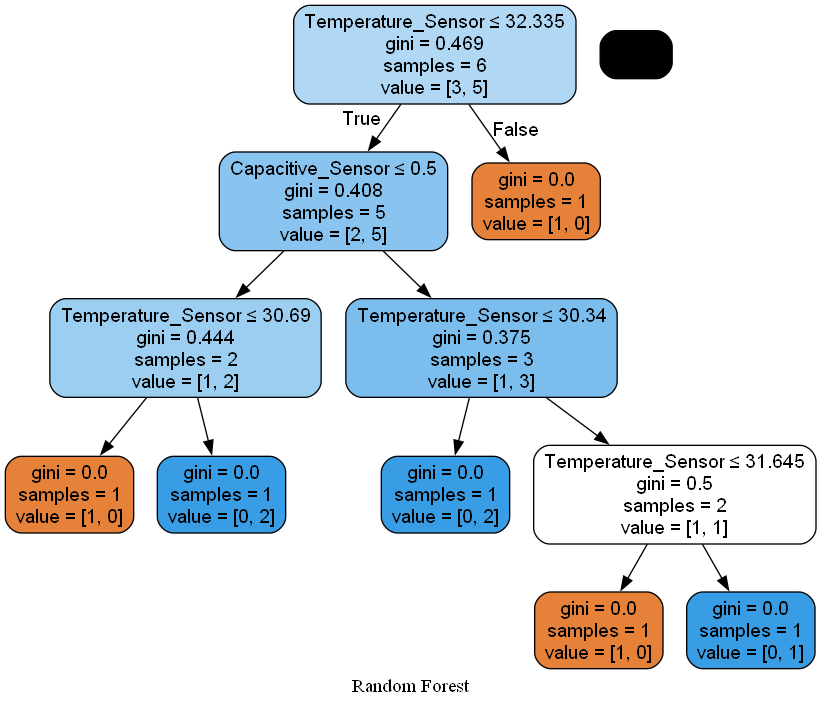

In [841]:
from IPython.display import Image  
from six import StringIO  
import pydotplus

# Visualize one of the trees in the Random Forest (for example, the first tree)
# Note: You can choose a different tree index based on your requirements
tree_to_visualize = 1
tree_visualization_data = StringIO()
tree.export_graphviz(clf.estimators_[tree_to_visualize], out_file=tree_visualization_data,
                     feature_names=features, filled=True, rounded=True, special_characters=True)


# Add a title to the PyDotPlus graph object
tree_graph = pydotplus.graph_from_dot_data(tree_visualization_data.getvalue())
tree_graph.set('label', 'Random Forest')

Image(tree_graph.create_png())

In [842]:
# Save the random forest tree visualization as a PNG file
output_file_path = "random_forest.png"
tree_graph.write_png(output_file_path)

True